<a href="https://colab.research.google.com/github/rpizarrog/machine_learning_r_python_casos_de_estudio/blob/main/notebook_Python/t_SNE_5000_estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-SNE 5000 estudiantes

# Objetivo

Consruir modelo t-SNE con datos académicos de estudiantes de nivel superior de una inastitucióin educativa.



# Desarrollo

## Cargar librerías


In [81]:
import pandas as pd # Para data.frames
import numpy as np # Para estructuras de datos
import matplotlib.pyplot as plt # Visualización gráfica
import seaborn as sns # Visualización gráfica
from sklearn.manifold import TSNE # Para construir el modelo
from sklearn.preprocessing import StandardScaler # Para normalziar datos
import time # Para medir tiempos de ejecución

## Cargar funciones

Se cargan funciones previamente preparadas para la ejecución del caso.


In [82]:
# Función que visualzia la dispersión de datos de un modelo t-SNE,
# recibe los datos de dos dimensiones y los datos originales las columnas categóricas
# recibe también las variables que son caterósticas y los títulos para personalziar visualaización
# Despliega 4 dispersiones de acuerdo a variables categóricas recibidas
def f_visualizar_dispersion_tSNE(datos_tsne_df, variables, titulos):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
    plt.style.use('seaborn-v0_8-whitegrid')

    for i, ax in enumerate(axes.flat):
        sns.scatterplot(
            x="Dimensión 1", y="Dimensión 2",
            hue=variables[i],
            style=variables[i],
            palette="viridis" if variables[i] not in ['carrera', 'trabaja', 'beca'] else "tab10" if variables[i] == 'carrera' else "viridis",
            data=datos_tsne_df,
            legend="full",
            alpha=0.7,
            ax=ax
        )
        ax.set_title(titulos[i])
        ax.set_xlabel('Dimensión 1 (t-SNE)')
        ax.set_ylabel('Dimensión 2 (t-SNE)')
        if variables[i] == 'carrera':
            ax.legend(loc='upper left')

    plt.suptitle('Análisis t-SNE de Perfiles de Estudiantes', fontsize=24, y=1.02)
    plt.tight_layout()
    plt.show()

# Cargar funciones para tablas HTML EPUB

In [83]:
# --- INSTALACIÓN ---
!pip -q install python-docx pandas numpy

import pandas as pd
import numpy as np
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.shared import OxmlElement, qn

# ====== UTILIDADES PARA DOCX ======
def _set_tbl_borders(table, show=False):
    """Bordes finos opcionales en header y perímetro; show=True para ver líneas."""
    if not show:
        # sin bordes (limpio)
        tbl = table._tbl
        borders = OxmlElement('w:tblBorders')
        for side in ('top','left','bottom','right','insideH','insideV'):
            e = OxmlElement(f'w:{side}')
            e.set(qn('w:val'), 'nil')
            borders.append(e)
        tbl.tblPr.append(borders)

def _apply_narrow_layout(doc):
    # Carta vertical, márgenes estándar
    for s in doc.sections:
        s.page_height = Inches(11)
        s.page_width  = Inches(8.5)
        s.top_margin    = Inches(1)
        s.bottom_margin = Inches(1)
        s.left_margin   = Inches(1)
        s.right_margin  = Inches(1)

def _wrap_header_text(name: str):
    # Forzar wraps suaves en encabezados largos:
    # - reemplaza '_' por salto de línea
    # - inserta salto antes de mayúsculas internas (CamelCase simple) para ayudar a envolver
    import re
    name = name.replace('_', '\n')
    name = re.sub(r'(?<!^)(?=[A-Z][a-z])', '\n', name)  # Ej: totalVentas -> total\nVentas
    return name

def _compute_equal_widths(num_cols, total_width_in=6.5):
    # Reparte ancho total de la tabla en columnas iguales
    w = total_width_in / max(1, num_cols)
    return [Inches(w)] * num_cols

def df_to_docx_narrow_table(df: pd.DataFrame, doc: Document, title: str,
                            total_width_in: float = 6.5,
                            font_size_pt: float = 9.5,
                            show_borders: bool = False):
    """
    Inserta una tabla 'angosta' en el Document:
      - una sola pieza (todas las columnas)
      - ancho fijo: table.autofit=False y anchos de columna iguales
      - tipografía compacta
      - encabezados con saltos de línea para evitar desbordes
    """
    # Título
    p = doc.add_paragraph(title)
    p.style = doc.styles['Heading 2']
    p.paragraph_format.space_after = Pt(6)

    # Conversión a str para evitar NaN
    safe = df.copy()
    for c in safe.columns:
        safe[c] = safe[c].astype(str)

    n_rows, n_cols = safe.shape
    table = doc.add_table(rows=0, cols=n_cols)
    _set_tbl_borders(table, show=show_borders)

    # Header
    hdr_cells = table.add_row().cells
    for j, col in enumerate(safe.columns):
        # Encabezado con posibles saltos de línea
        header_text = _wrap_header_text(str(col))
        # Escribimos con saltos reales en Word
        para = hdr_cells[j].paragraphs[0]
        for k, frag in enumerate(header_text.split('\n')):
            run = para.add_run(frag if k == 0 else ("\n" + frag))
            run.bold = True
            run.font.size = Pt(font_size_pt)
        para.alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Filas
    for i in range(n_rows):
        row_cells = table.add_row().cells
        for j, col in enumerate(safe.columns):
            para = row_cells[j].paragraphs[0]
            run = para.add_run(str(safe.iloc[i, j]))
            run.font.size = Pt(font_size_pt)
            para.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Anchos fijos
    table.autofit = False
    col_widths = _compute_equal_widths(n_cols, total_width_in=total_width_in)
    for j, w in enumerate(col_widths):
        table.columns[j].width = w
        # Forzar ancho "preferido"
        for cell in table.columns[j].cells:
            cell.width = w

    # Espacio después de la tabla
    doc.add_paragraph("")

def export_docx_narrow(head10, tail10,
                       path_docx_both="tablas_datos_head_tail_word_narrow.docx",
                       path_docx_head="tablas_datos_head10_word_narrow.docx",
                       path_docx_tail="tablas_datos_tail10_word_narrow.docx",
                       total_width_in=6.5, font_size_pt=9.5, show_borders=False):
    # Documento con ambas tablas (una debajo de la otra)
    doc_both = Document()
    _apply_narrow_layout(doc_both)
    df_to_docx_narrow_table(head10, doc_both, "Vista previa (primeros 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    df_to_docx_narrow_table(tail10, doc_both, "Vista previa (últimos 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_both.save(path_docx_both)

    # Documentos individuales
    doc_h = Document(); _apply_narrow_layout(doc_h)
    df_to_docx_narrow_table(head10, doc_h, "Vista previa (primeros 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_h.save(path_docx_head)

    doc_t = Document(); _apply_narrow_layout(doc_t)
    df_to_docx_narrow_table(tail10, doc_t, "Vista previa (últimos 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_t.save(path_docx_tail)

# ====== HTML EN UNA SOLA TABLA ANGOSTA ======
def df_to_html_narrow_single_table(df: pd.DataFrame, title: str = "", table_width_px: int = 700):
    safe = df.copy()
    for c in safe.columns:
        safe[c] = safe[c].astype(str)

    # CSS: tabla angosta, layout fijo, wrap agresivo
    css = f"""
    <style>
      body {{ font-family: Arial, Helvetica, sans-serif; font-size: 12pt; line-height: 1.35; margin: 0; padding: 0.2in; }}
      h2 {{ font-size: 14pt; margin: 0 0 0.15in 0; }}
      table.narrow {{
        width: {table_width_px}px;
        table-layout: fixed;
        border-collapse: collapse;
        border: 1px solid #ddd;
        font-size: 10pt;
      }}
      table.narrow th, table.narrow td {{
        border: 1px solid #ddd;
        padding: 6px 8px;
        vertical-align: top;
        word-wrap: break-word;
        overflow-wrap: anywhere;
        white-space: normal;
      }}
      table.narrow th {{
        background: #f4f4f4;
        text-align: center;
        font-weight: bold;
      }}
    </style>
    """

    # Encabezados con "soft wrap": reemplaza '_' por <br>
    def wrap_header(col):
        import re
        col = str(col).replace('_', '<br>')
        col = re.sub(r'(?<!^)(?=[A-Z][a-z])', '<br>', col)
        return col

    html = [f"<!DOCTYPE html><html><head><meta charset='utf-8'>{css}</head><body>"]
    if title:
        html.append(f"<h2>{title}</h2>")
    html.append("<table class='narrow'><thead><tr>")
    for col in safe.columns:
        html.append(f"<th>{wrap_header(col)}</th>")
    html.append("</tr></thead><tbody>")

    for _, row in safe.iterrows():
        html.append("<tr>")
        for col in safe.columns:
            html.append(f"<td>{row[col]}</td>")
        html.append("</tr>")
    html.append("</tbody></table></body></html>")
    return "".join(html)

def export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_ventas_head10tail10_epub_narrow.html",
    path_html_head="tablas_datos_head10_epub_narrow.html",
    path_html_tail="tablas_datos_tail10_epub_narrow.html",
    table_width_px=700,
    modo="dos_tablas"  # "dos_tablas" (2 tablas en una página) o "una_tabla" (head+tail concatenados)
):
    """
    Requiere que exista df_to_html_narrow_single_table(df, title="", table_width_px=700)
    y que 'head10' y 'tail10' sean DataFrames.
    """

    # HTML individuales
    h_head = df_to_html_narrow_single_table(head10, "Vista previa (primeros 10 registros)", table_width_px)
    h_tail = df_to_html_narrow_single_table(tail10, "Vista previa (últimos 10 registros)", table_width_px)

    # Guardar individuales
    with open(path_html_head, "w", encoding="utf-8") as f:
        f.write(h_head)
    with open(path_html_tail, "w", encoding="utf-8") as f:
        f.write(h_tail)

    # Combinar en un solo HTML
    if modo == "dos_tablas":
        # Reutiliza el <head> (con CSS) del primero y mete ambos <body> uno tras otro
        def body_only(html):
            s = html.lower().find("<body>")
            e = html.lower().find("</body>")
            return html[s+6:e].strip() if s != -1 and e != -1 else html

        h_start = h_head.lower().find("<head>")
        h_end   = h_head.lower().find("</head>")
        head_block = h_head[h_start:h_end+7] if h_start != -1 and h_end != -1 else "<head><meta charset='utf-8'></head>"

        combined = [
            "<!DOCTYPE html><html>",
            head_block,
            "<body>",
            # botones de navegación internos (opcional)
            "<p><a href='#head10'>Ir a head(10)</a> | <a href='#tail10'>Ir a tail(10)</a></p>",
            "<div id='head10'>", body_only(h_head), "</div>",
            "<hr style='margin:0.2in 0;border:0;border-top:1px solid #ddd;'>",
            "<div id='tail10'>", body_only(h_tail), "</div>",
            "</body></html>"
        ]
        html_headtail = "".join(combined)

    elif modo == "una_tabla":
        import pandas as pd
        head_tag = head10.copy()
        tail_tag = tail10.copy()
        head_tag.insert(0, "_sección_", "head(10)")
        tail_tag.insert(0, "_sección_", "tail(10)")
        df_union = pd.concat([head_tag, tail_tag], ignore_index=True)
        html_headtail = df_to_html_narrow_single_table(
            df_union, "Vista previa (head(10)+tail(10) en una sola tabla)", table_width_px
        )
    else:
        raise ValueError("modo debe ser 'dos_tablas' o 'una_tabla'")

    with open(path_html_headtail, "w", encoding="utf-8") as f:
        f.write(html_headtail)

    # print("Listo. Archivos generados:")
    # print(" -", path_html_headtail)
    # print(" -", path_html_head)
    # print(" -", path_html_tail)

## Cargar datos



In [84]:
datos_originales = pd.read_csv('https://raw.githubusercontent.com/rpizarrog/machine_learning_r_python_casos_de_estudio/refs/heads/main/datos/datos_estudiantes5000_tSNE.csv')


# Modificar nombres de columnas


In [85]:
# Diccionario de nombres cortos
renombrar = {
    'promedio_kardex': 'prom',
    'horas_estudio': 'estudio',
    'asistencias': 'asist',
    'unidades_aprobadas': 'unids',
    'nivel_estres': 'estres',
    'motivacion': 'motiv',
    'beca': 'beca',
    'trabaja': 'trab',
    'perfil_rendimiento': 'perfil',
    'edad': 'edad',
    'horas_ocio': 'ocio',
    'integrantes_familia': 'familia',
    'ingresos_familiares': 'ingresos',
    'actividades_extracurriculares': 'extracurr',
    'participacion_clase': 'participa',
    'apoyo_gubernamental': 'apoyo',
    'habilidades_blandas': 'blandas',
    'sociabilidad': 'social',
    'semestre': 'sem',
    'materias_cursando': 'materias',
    'carrera': 'car'
}

# Aplicar renombramiento
datos = datos_originales.rename(columns=renombrar)

# Verificar resultado
print(datos.columns.tolist())


['prom', 'estudio', 'asist', 'unids', 'estres', 'motiv', 'beca', 'trab', 'perfil', 'edad', 'ocio', 'familia', 'ingresos', 'extracurr', 'participa', 'apoyo', 'blandas', 'social', 'sem', 'materias', 'car']


## Explorar datos

Estructura de los datos

In [86]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   prom       5000 non-null   float64
 1   estudio    5000 non-null   int64  
 2   asist      5000 non-null   int64  
 3   unids      5000 non-null   int64  
 4   estres     5000 non-null   int64  
 5   motiv      5000 non-null   int64  
 6   beca       5000 non-null   object 
 7   trab       5000 non-null   object 
 8   perfil     5000 non-null   object 
 9   edad       5000 non-null   int64  
 10  ocio       5000 non-null   int64  
 11  familia    5000 non-null   int64  
 12  ingresos   5000 non-null   int64  
 13  extracurr  5000 non-null   int64  
 14  participa  5000 non-null   int64  
 15  apoyo      5000 non-null   object 
 16  blandas    5000 non-null   float64
 17  social     5000 non-null   float64
 18  sem        5000 non-null   int64  
 19  materias   5000 non-null   int64  
 20  car     

## Primeros y últimos registros

Filtrar solo algunas columnas


In [87]:
# Seleccionamos solo columnas numéricas
head10_num = datos.select_dtypes(include='number')

# Palabras clave que te interesan
claves = ['prom', 'estudio', 'asist', 'unids', 'estres', 'motiv',
          'edad', 'ocio', 'familia', 'ingresos', 'materias']

# Filtrar las columnas cuyo nombre contenga alguna clave
cols_filtradas = [col for col in head10_num.columns if any(c in col.lower() for c in claves)]

# Crear el subconjunto con las primeras 10 filas
head10 = head10_num[cols_filtradas].head(10)

# --- Insertar la columna "varios" antes de la última ---
# Obtener nombre de la última columna (debe ser 'materias' o similar)
ultima = head10.columns[-1]

# Insertar antes de la última posición
posicion = head10.columns.get_loc(ultima)
head10.insert(posicion, 'varios', '...')

# Mostrar resultado
head10



,prom,estudio,asist,unids,estres,motiv,edad,ocio,familia,ingresos,varios,materias
0,100.0,4,99,10,2,9,22,3,2,42481,...,6
1,86.6,2,80,8,5,5,19,5,3,15043,...,7
2,85.0,3,81,8,7,8,23,5,1,21782,...,5
3,76.7,2,73,5,8,2,21,1,5,7388,...,7
4,96.7,4,97,9,1,8,19,1,6,27103,...,5
5,76.1,1,80,2,9,2,23,1,2,9102,...,6
6,95.4,3,100,8,3,10,22,5,2,42432,...,6
7,83.6,2,82,8,4,7,18,5,1,5536,...,5
8,90.0,3,80,7,5,8,24,3,3,10575,...,5
9,74.1,1,83,2,7,2,22,4,6,9578,...,6


Últimos registros


In [88]:
# Seleccionamos solo columnas numéricas
tail10_num = datos.select_dtypes(include='number')


# Filtramos las columnas cuyo nombre contenga alguna clave
cols_filtradas = [col for col in tail10_num.columns if any(c in col.lower() for c in claves)]

# Creamos el subconjunto con las primeras 10 filas
tail10 = tail10_num[cols_filtradas].tail(10)

# --- Insertar la columna "varios" antes de la última ---
# Obtener nombre de la última columna (debe ser 'materias' o similar)
ultima = tail10.columns[-1]

# Insertar antes de la última posición
posicion = tail10.columns.get_loc(ultima)
tail10.insert(posicion, 'varios', '...')

# Mostrar resultado
tail10

,prom,estudio,asist,unids,estres,motiv,edad,ocio,familia,ingresos,varios,materias
4990,85.1,2,95,8,5,8,21,2,3,22332,...,4
4991,95.9,4,98,9,1,8,23,3,7,14369,...,7
4992,84.2,3,83,6,7,8,19,1,4,21776,...,6
4993,96.2,3,97,9,1,9,22,2,4,14579,...,5
4994,87.6,3,86,6,5,5,20,3,2,37714,...,7
4995,81.3,2,89,7,7,8,19,1,4,37448,...,6
4996,82.8,4,93,6,4,7,22,5,5,7028,...,7
4997,84.9,4,83,8,6,5,24,3,2,18367,...,5
4998,94.4,3,98,9,3,9,22,4,3,47267,...,5
4999,70.0,2,70,5,9,4,19,4,4,35358,...,7


# Generar HTML para EPUB


In [89]:
export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_estudiantes_head10tail10_epub_narrow.html",
    path_html_head="tablas_datos_estudiantes_head10_epub_narrow.html",
    path_html_tail="tablas_datos_estudiantes_tail10_epub_narrow.html",
    table_width_px=680,
    modo="dos_tablas"  # o "una_tabla"
)

print("Listo. Archivos generados:")

print("tablas_datos_estudiantes_head10tail10_epub_narrow.html")
print("tablas_datos_estudiantes_head10_epub_narrow.html")
print("tablas_datos_estudiantes_tail10_epub_narrow.html")

Listo. Archivos generados:
tablas_datos_estudiantes_head10tail10_epub_narrow.html
tablas_datos_estudiantes_head10_epub_narrow.html
tablas_datos_estudiantes_tail10_epub_narrow.html


# Primeros y últimos registros datos categóricos


In [90]:
head10 = datos.select_dtypes(include='object').head(10)
head10




,beca,trab,perfil,apoyo,car
0,Sí,No,Alto Rendimiento,No,Ing. Gestión Empresarial
1,No,Sí,Rendimiento Promedio,No,Ing. Industrial
2,No,No,Rendimiento Promedio,Sí,Ing. Electrónica
3,No,No,Bajo Rendimiento,No,Ing. Química
4,No,No,Alto Rendimiento,No,Ing. Civil
5,No,No,Bajo Rendimiento,Sí,Ing. Civil
6,Sí,Sí,Alto Rendimiento,Sí,Ing. Química
7,No,Sí,Rendimiento Promedio,Sí,Ing. Química
8,No,No,Rendimiento Promedio,No,Ing. Bioquímica
9,No,No,Bajo Rendimiento,Sí,Ing. Gestión Empresarial


In [91]:
tail10 = datos.select_dtypes(include='object').tail(10)
tail10


,beca,trab,perfil,apoyo,car
4990,No,Sí,Rendimiento Promedio,No,Arquitectura
4991,Sí,Sí,Alto Rendimiento,No,Ing. Industrial
4992,No,Sí,Rendimiento Promedio,Sí,Ing. Química
4993,Sí,No,Alto Rendimiento,No,Ing. Química
4994,No,No,Rendimiento Promedio,No,Arquitectura
4995,No,No,Rendimiento Promedio,No,Ing. Civil
4996,No,Sí,Rendimiento Promedio,No,Ing. Gestión Empresarial
4997,No,Sí,Rendimiento Promedio,Sí,Ing. Industrial
4998,Sí,No,Alto Rendimiento,No,Ing. Química
4999,No,No,Bajo Rendimiento,Sí,Ing. Sistemas


In [92]:
export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_cat_estudiantes_head10tail10_epub_narrow.html",
    path_html_head="tablas_datos_cat_estudiantes_head10_epub_narrow.html",
    path_html_tail="tablas_datos_cat_estudiantes_tail10_epub_narrow.html",
    table_width_px=680,
    modo="dos_tablas"  # o "una_tabla"
)

print("Listo. Archivos generados:")

print("tablas_datos_cat_estudiantes_head10tail10_epub_narrow.html")
print("tablas_datos_cat_estudiantes_head10_epub_narrow.html")
print("tablas_datos_cat_estudiantes_tail10_epub_narrow.html")

Listo. Archivos generados:
tablas_datos_cat_estudiantes_head10tail10_epub_narrow.html
tablas_datos_cat_estudiantes_head10_epub_narrow.html
tablas_datos_cat_estudiantes_tail10_epub_narrow.html


## Análisis descriptivo de los datos

Datos numéricos


In [93]:
print(datos.describe())

              prom     estudio        asist        unids       estres  \
count  5000.000000  5000.00000  5000.000000  5000.000000  5000.000000   
mean     85.037820     2.79920    87.355000     6.275600     5.510000   
std       6.879353     0.98177     7.475998     2.257845     2.219569   
min      70.000000     1.00000    70.000000     1.000000     1.000000   
25%      80.800000     2.00000    82.000000     5.000000     4.000000   
50%      85.100000     3.00000    87.000000     7.000000     6.000000   
75%      89.200000     4.00000    94.000000     8.000000     7.000000   
max     100.000000     5.00000   100.000000    10.000000    10.000000   

             motiv         edad         ocio      familia      ingresos  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean      6.179800    21.474200     3.014800     3.034600  27646.755000   
std       2.316753     2.304343     1.419783     1.610317  12969.800545   
min       1.000000    18.000000     1.0000

Datos cateóricos

In [94]:
datos.describe(include='object')

,beca,trab,perfil,apoyo,car
count,5000,5000,5000,5000,5000
unique,2,2,3,2,10
top,No,No,Rendimiento Promedio,No,Ing. Gestión Empresarial
freq,3495,2511,3000,3466,817


## Estructura de los datos

## Preparar datos


In [95]:
# --- Aplicación del modelo t-SNE ---
# Seleccionar solo las variables numéricas para el modelo t-SNE
variables_numericas = datos.select_dtypes(include=np.number).columns.tolist()
df_modelo = datos[variables_numericas]

print("Variables numéricas")

datos_escalados = StandardScaler().fit_transform(df_modelo)
# Convertir el array de NumPy a un DataFrame de pandas
df_escalado = pd.DataFrame(datos_escalados, columns=df_modelo.columns)
head10_escalado = df_escalado.head(10)

# 4 posiciones decimales el escalado
head10_escalado = np.round(head10_escalado, 4)



# Filtrar las columnas cuyo nombre contenga alguna clave
cols_filtradas = [col for col in head10_escalado.columns if any(c in col.lower() for c in claves)]

# Crear el subconjunto con las primeras 10 filas
head10 = head10_escalado[cols_filtradas].head(10)

# --- Insertar la columna "varios" antes de la última ---
# Obtener nombre de la última columna (debe ser 'materias' o similar)
ultima = head10.columns[-1]

# Insertar antes de la última posición
posicion = head10.columns.get_loc(ultima)
head10.insert(posicion, 'varios', '...')

# Mostrar resultado
head10



Variables numéricas


,prom,estudio,asist,unids,estres,motiv,edad,ocio,familia,ingresos,varios,materias
0,2.1752,1.2232,1.5578,1.6497,-1.5815,1.2174,0.2282,-0.0104,-0.6425,1.1439,...,0.0731
1,0.2271,-0.8141,-0.9839,0.7638,-0.2298,-0.5093,-1.0738,1.3984,-0.0215,-0.9719,...,1.1778
2,-0.0055,0.2045,-0.8501,0.7638,0.6714,0.7857,0.6622,1.3984,-1.2636,-0.4522,...,-1.0316
3,-1.2121,-0.8141,-1.9203,-0.5650,1.1220,-1.8043,-0.2058,-1.4192,1.2206,-1.5622,...,1.1778
4,1.6954,1.2232,1.2903,1.2068,-2.0321,0.7857,-1.0738,-1.4192,1.8417,-0.0419,...,-1.0316
5,-1.2994,-1.8328,-0.9839,-1.8939,1.5725,-1.8043,0.6622,-1.4192,-0.6425,-1.4300,...,0.0731
6,1.5064,0.2045,1.6916,0.7638,-1.1310,1.6491,0.2282,1.3984,-0.6425,1.1401,...,0.0731
7,-0.2090,-0.8141,-0.7164,0.7638,-0.6804,0.3541,-1.5078,1.3984,-1.2636,-1.7050,...,-1.0316
8,0.7214,0.2045,-0.9839,0.3209,-0.2298,0.7857,1.0962,-0.0104,-0.0215,-1.3164,...,-1.0316
9,-1.5901,-1.8328,-0.5826,-1.8939,0.6714,-1.8043,0.2282,0.6940,1.8417,-1.3933,...,0.0731


In [96]:
tail10_escalado = df_escalado.tail(10)

# 4 posiciones decimales el escalado
tail10_escalado = np.round(tail10_escalado, 4)



# Filtrar las columnas cuyo nombre contenga alguna clave
cols_filtradas = [col for col in tail10_escalado.columns if any(c in col.lower() for c in claves)]

# Crear el subconjunto con las primeras 10 filas
tail10 = tail10_escalado[cols_filtradas].tail(10)

# --- Insertar la columna "varios" antes de la última ---
# Obtener nombre de la última columna (debe ser 'materias' o similar)
ultima = tail10.columns[-1]

# Insertar antes de la última posición
posicion = tail10.columns.get_loc(ultima)
tail10.insert(posicion, 'varios', '...')

# Mostrar resultado
tail10

,prom,estudio,asist,unids,estres,motiv,edad,ocio,familia,ingresos,varios,materias
4990,0.0090,-0.8141,1.0227,0.7638,-0.2298,0.7857,-0.2058,-0.7148,-0.0215,-0.4098,...,-2.1363
4991,1.5791,1.2232,1.4240,1.2068,-2.0321,0.7857,0.6622,-0.0104,2.4627,-1.0238,...,1.1778
4992,-0.1218,0.2045,-0.5826,-0.1221,0.6714,0.7857,-1.0738,-1.4192,0.5996,-0.4527,...,0.0731
4993,1.6227,0.2045,1.2903,1.2068,-2.0321,1.2174,0.2282,-0.7148,0.5996,-1.0077,...,-1.0316
4994,0.3725,0.2045,-0.1813,-0.1221,-0.2298,-0.5093,-0.6398,-0.0104,-0.6425,0.7763,...,1.1778
4995,-0.5434,-0.8141,0.2201,0.3209,0.6714,0.7857,-1.0738,-1.4192,0.5996,0.7558,...,0.0731
4996,-0.3253,1.2232,0.7552,-0.1221,-0.6804,0.3541,0.2282,1.3984,1.2206,-1.5899,...,1.1778
4997,-0.0200,1.2232,-0.5826,0.7638,0.2208,-0.5093,1.0962,-0.0104,-0.6425,-0.7156,...,-1.0316
4998,1.3610,0.2045,1.4240,1.2068,-1.1310,1.2174,0.2282,0.6940,-0.0215,1.5129,...,-1.0316
4999,-2.1862,-0.8141,-2.3217,-0.5650,1.5725,-0.9410,-1.0738,0.6940,0.5996,0.5946,...,1.1778


# Tablas de los datos escalados HTML para EPUB


In [97]:
export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_estudiantes_escalados_head10tail10_epub_narrow.html",
    path_html_head="tablas_datos_estudiantes_escalados_head10_epub_narrow.html",
    path_html_tail="tablas_datos_estudiantes_escalados_tail10_epub_narrow.html",
    table_width_px=680,
    modo="dos_tablas"  # o "una_tabla"
)

print("Listo. Archivos generados:")

print("tablas_datos_estudiantes_escalados_head10tail10_epub_narrow.html")
print("tablas_datos_estudiantes_escalados_head10_epub_narrow.html")
print("tablas_datos_estudiantes_escalados_tail10_epub_narrow.html")

Listo. Archivos generados:
tablas_datos_estudiantes_escalados_head10tail10_epub_narrow.html
tablas_datos_estudiantes_escalados_head10_epub_narrow.html
tablas_datos_estudiantes_escalados_tail10_epub_narrow.html


df_escalado.head()

# Construir el modelo t-SNE

El modelo t-SNE se construye con dos dimensiones con valor de perplejidad de *50*, número de iteracciones de *1000* y valor aleatorio de *2025* para reproducir los mismos resultados.

Se incorpora un temporizador de reloj para medir el tiempo de construcción del modelo; el tiempo aproximado de ejecución en equpo *laptop* con procesador *12th Gen., Intel y 32 GB en RAM* es de 90 segundos.

Se utiliza el conjunto de datos escalados.


In [98]:
# Construcción del modelo t-SNE
# Iniciar el temporizador
start_time = time.time()

# Construcción y ajuste del modelo t-SNE
tsne_model = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=2025)
datos_dos_dimensiones = tsne_model.fit_transform(df_escalado)

# Detener el temporizador y calcular el tiempo transcurrido
end_time = time.time()
tiempo_total = end_time - start_time
print(f"Tiempo total de ejecución: {tiempo_total} segundos")


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Tiempo total de ejecución: 53.55704641342163 segundos


## Matriz final de dos dimensiones

Se hace un conjunto de datos con la matriz final de dos dimensiones que representan las similitudes de las variables numéricas de los datos originales, integrando las variables de las columnas categóricas para prpósitos de análisis.


In [99]:
datos_tsne_df = pd.DataFrame(data=datos_dos_dimensiones, columns=['Dimensión 1', 'Dimensión 2'])
datos_tsne_df['perfil_rendimiento'] = datos_originales['perfil_rendimiento'].values
datos_tsne_df['carrera'] = datos_originales['carrera'].values
datos_tsne_df['trabaja'] = datos_originales['trabaja'].values
datos_tsne_df['beca'] = datos_originales['beca'].values
datos_tsne_df

,Dimensión 1,Dimensión 2,perfil_rendimiento,carrera,trabaja,beca
0,58.606731,-8.877673,Alto Rendimiento,Ing. Gestión Empresarial,No,Sí
1,-0.621603,-13.371014,Rendimiento Promedio,Ing. Industrial,Sí,No
2,-10.756411,-4.442816,Rendimiento Promedio,Ing. Electrónica,No,No
3,-51.615776,-1.830671,Bajo Rendimiento,Ing. Química,No,No
4,38.353149,-5.821732,Alto Rendimiento,Ing. Civil,No,No
...,...,...,...,...,...,...
4995,-10.734580,5.953188,Rendimiento Promedio,Ing. Civil,No,No
4996,6.325993,-13.854565,Rendimiento Promedio,Ing. Gestión Empresarial,Sí,No
4997,9.696661,17.478889,Rendimiento Promedio,Ing. Industrial,Sí,No
4998,54.503292,-10.318597,Alto Rendimiento,Ing. Química,No,Sí


# Visualizar el modelo t-SNE

Se presenta el diagrama de dispersión del modelo t-SNE para de los datos de *5000* estudiantes.

Se utiliza la función *f_visualizar_dispersion_tSNE* previamente cargada.


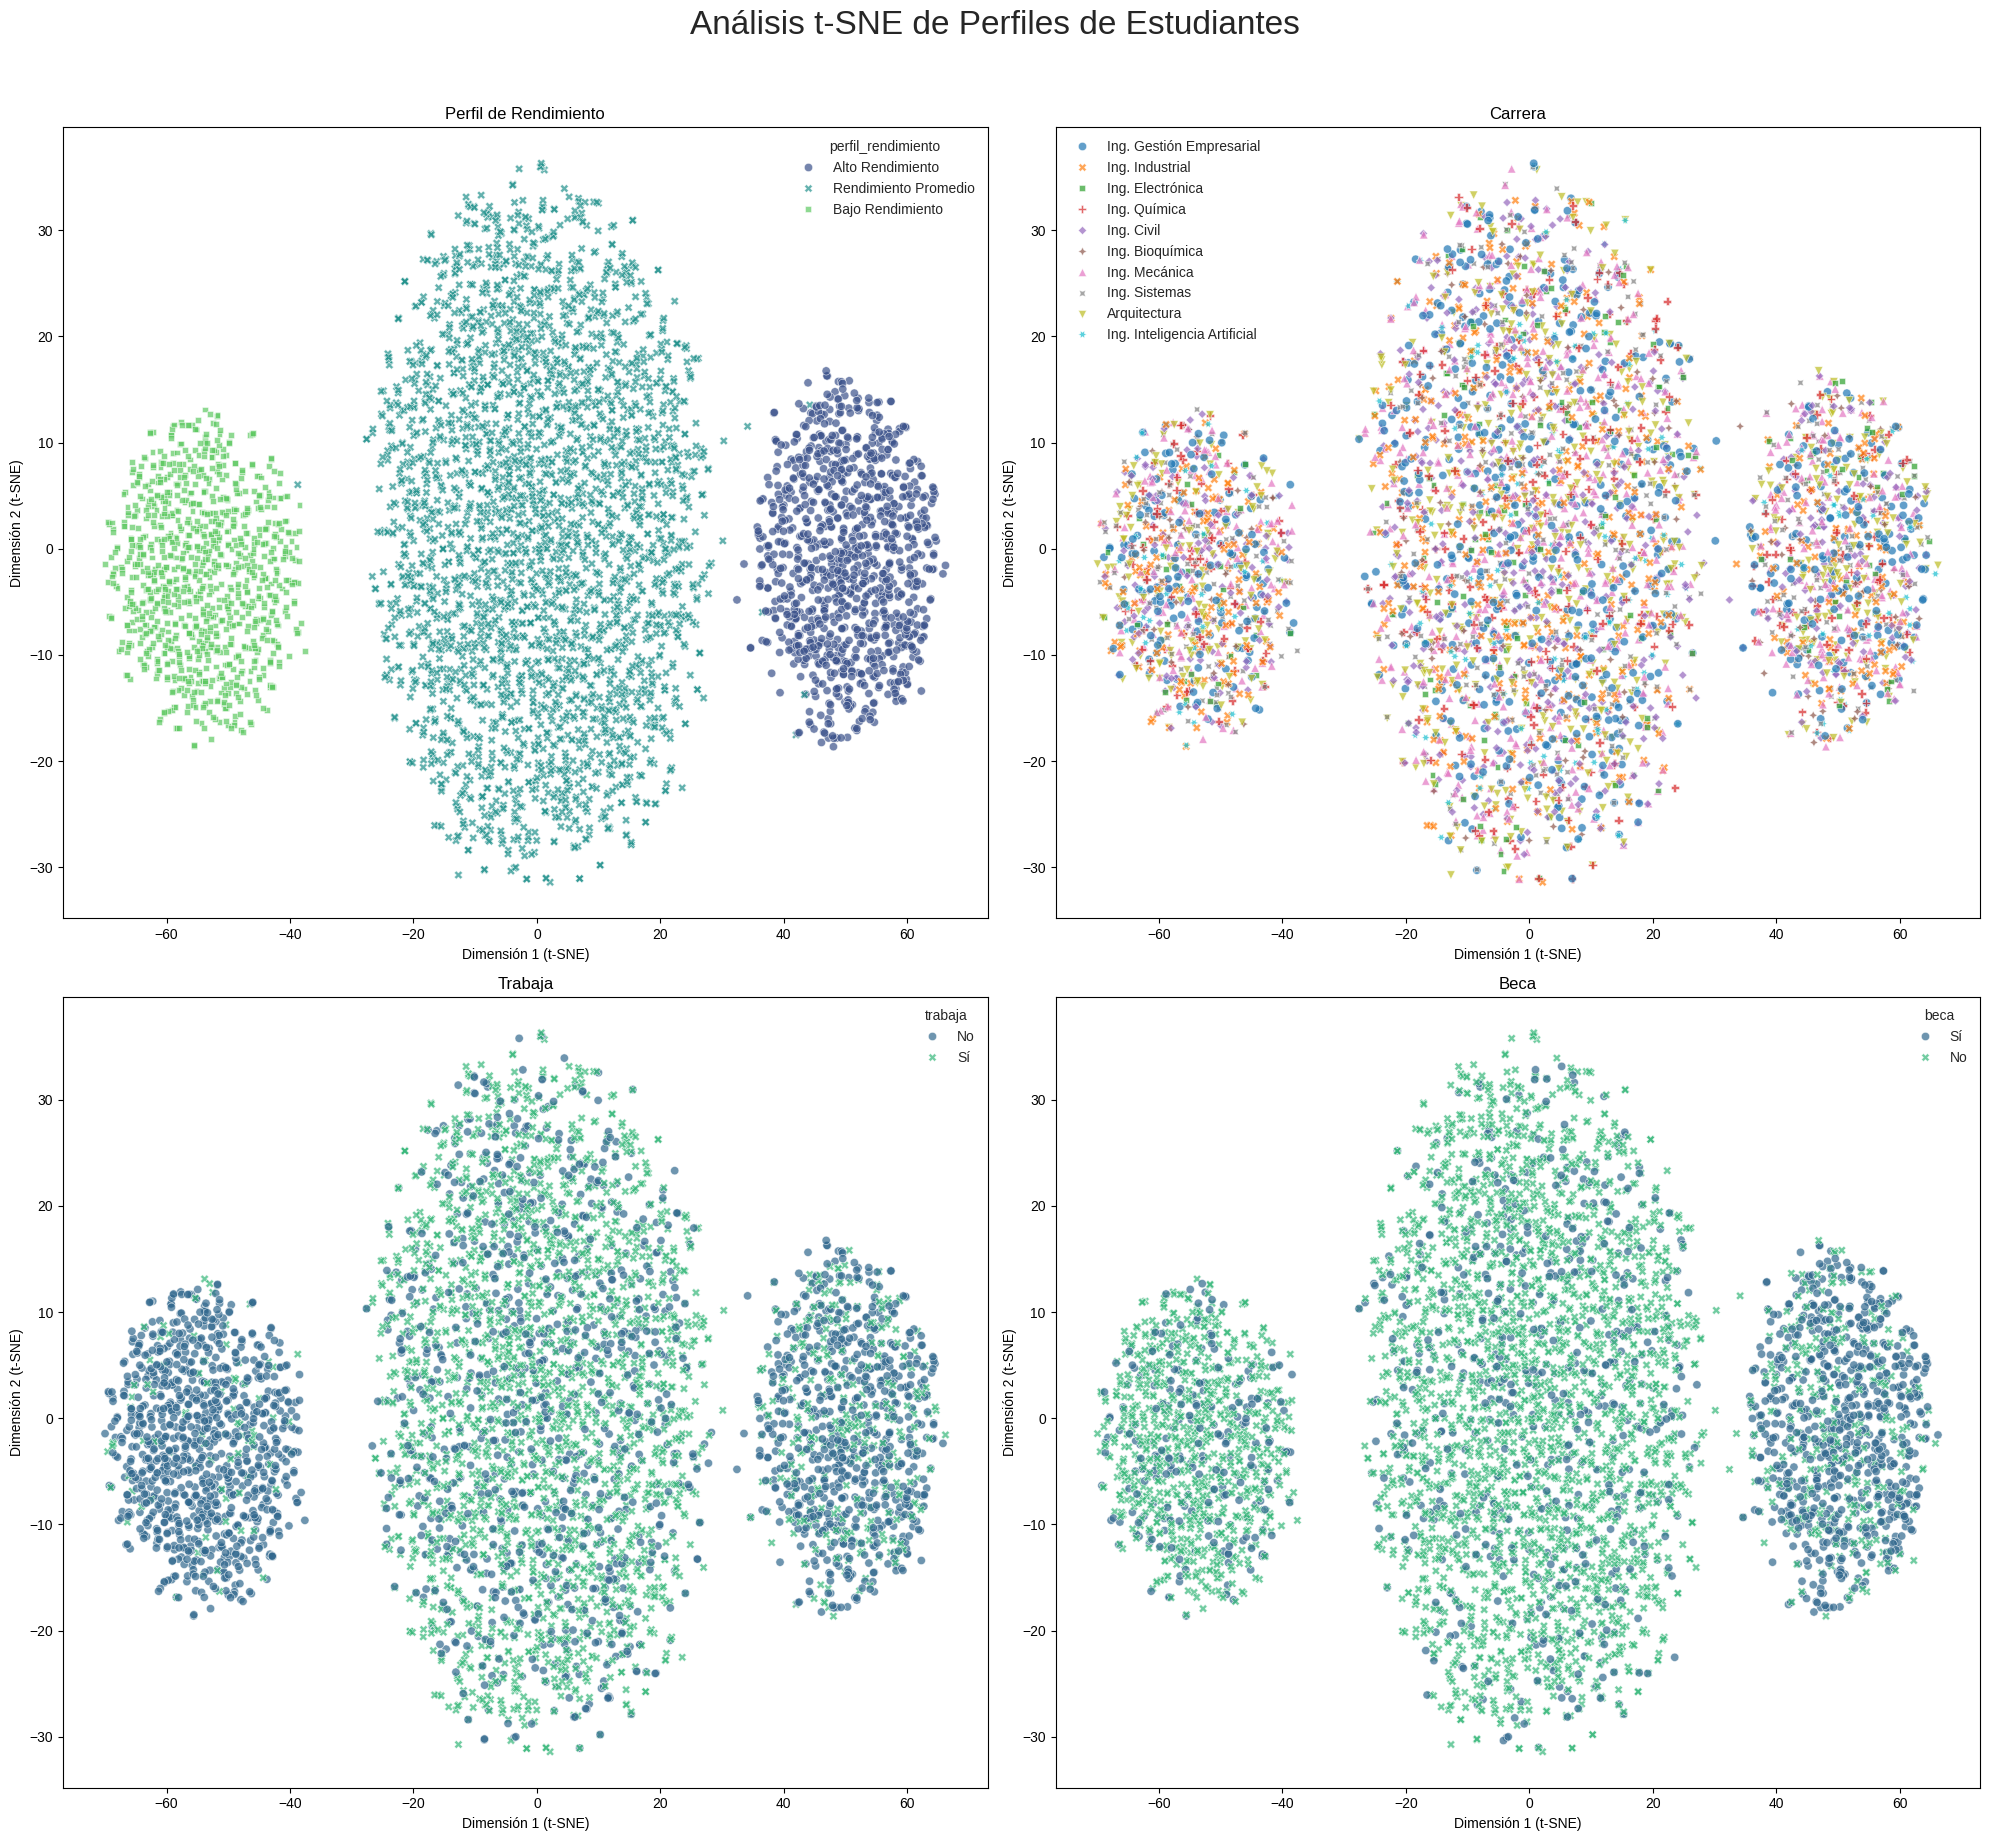

In [100]:
variables = ['perfil_rendimiento', 'carrera', 'trabaja', 'beca']
titulos = ['Perfil de Rendimiento', 'Carrera', 'Trabaja', 'Beca']
# Llamada a la función para generar la matriz de gráficos
f_visualizar_dispersion_tSNE(datos_tsne_df, variables, titulos)

# Interpretación

Con los datos de estudaintes y habiendo aplicado el modelo t-SNE a dos dimensiones, las gráficas se interpretan de la siguiente manera:

Se obsreva en el diagrama de dispersión de los datos arriba a la izquierda que existen tres grupos perfectamente definidos y que van en relación al rendimiento académicos, los de alto, promedio y bajo rendimiento.

En el diagrama arriba derecha se observa una mezcla de estudiantes de distintas carreras, no existe una clara distinción de los tres grupos asociado las carreras.

En la gráfica abajo a la izquierda, existe un grupo que tiene que ver con aquellos estudiantes que trabajan, en su gran mayoría tienen rendimientos promedios pero no existen o hay muy pocos estudiantes con bajo rendimiento, lo que lleva tal vez a inferir que el trabajo ayuda a la responsabilidad académica para alcanzar un promedio en rendimiento escolar.

Finalmente, en la gráfica de abajo a la derecha, se observa que hay una relación entre los alumnos que tienen beca con el rendumiento alto, lo que lleva es que precisamnte las becas académicas de estímulos va asociado a la exigencia de buenas notas académicas.



